In this file I am using TEXT (combination of Title, Tagline and Overview) vectorized using BERT for the main feature to predict Movie Genres. Following the steps I performed:
1. Preprocess the dataset for BERT, just simple preprocessing since BERT knows context already.
2. Split the Train Dataset to be used in Modelling. It would be split into X_train, y_train, X_test, y_test.
3. Embedding the X_train, X_test using BERT.
4. Perform modelling using Random Forest, Log Regression, SVC, MLP and XGB Method.
5. So far, Log Regression give the best result either by F1 metrics or coverage-length metrics.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report



In [2]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_test.csv to cleaned_test.csv
Saving cleaned_train.csv to cleaned_train.csv


In [3]:
df_train = pd.read_csv('cleaned_train.csv')
df_test = pd.read_csv('cleaned_test.csv')

In [ ]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2386 non-null   int64  
 1   budget             2386 non-null   float64
 2   homepage           857 non-null    object 
 3   original_language  2386 non-null   object 
 4   original_title     2386 non-null   object 
 5   overview           2386 non-null   object 
 6   release_date       2386 non-null   object 
 7   revenue            2386 non-null   float64
 8   runtime            2386 non-null   float64
 9   status             2386 non-null   object 
 10  tagline            1965 non-null   object 
 11  title              2386 non-null   object 
 12  vote_average       2386 non-null   float64
 13  vote_count         2386 non-null   float64
 14  Action             2386 non-null   int64  
 15  Adventure          2386 non-null   int64  
 16  Animation          2386 

In [4]:
# Dealing with null values
df_train['tagline'].fillna('-', inplace=True)
df_train['homepage'].fillna('-', inplace=True)


<ipython-input-4-bb2d39715fee>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['tagline'].fillna('-', inplace=True)
<ipython-input-4-bb2d39715fee>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2386 non-null   int64  
 1   budget             2386 non-null   float64
 2   homepage           2386 non-null   object 
 3   original_language  2386 non-null   object 
 4   original_title     2386 non-null   object 
 5   overview           2386 non-null   object 
 6   release_date       2386 non-null   object 
 7   revenue            2386 non-null   float64
 8   runtime            2386 non-null   float64
 9   status             2386 non-null   object 
 10  tagline            2386 non-null   object 
 11  title              2386 non-null   object 
 12  vote_average       2386 non-null   float64
 13  vote_count         2386 non-null   float64
 14  Action             2386 non-null   int64  
 15  Adventure          2386 non-null   int64  
 16  Animation          2386 

### 1. PREPROCESS THE TEXT COLUMNS

In [5]:
!pip install unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.2 MB/s eta 0:00:00


In [6]:
import pandas as pd
import html
import re
import unidecode

# Preprocessing for BERT
def text_preprocess_bert(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    text = html.unescape(text)
    text = unidecode.unidecode(text)
    text = re.sub(r'http\S+|www\S+|https\S+|\S+@\S+', '', text, flags=re.MULTILINE)
    text = text.lower()
    return text.strip()

# combining the text
def combine_processed_text(df):
    return df['processed_title'] + ' ' + df['processed_tagline'] + ' ' + df['processed_overview']

# run preprocessing
preprocessed_data = False

if not preprocessed_data:
    for df in [df_train, df_test]:
        df['processed_title'] = df['title'].apply(lambda x: text_preprocess_bert(str(x)) if pd.notnull(x) else '')
        df['processed_tagline'] = df['tagline'].apply(lambda x: text_preprocess_bert(str(x)) if pd.notnull(x) else '')
        df['processed_overview'] = df['overview'].apply(lambda x: text_preprocess_bert(str(x)) if pd.notnull(x) else '')

    # combining in 1 column
    df_train['text'] = combine_processed_text(df_train)
    df_test['text'] = combine_processed_text(df_test)

    # Saving
    df_train.to_csv('movies_genres_train_preprocessed_bert.csv', index=False)
    df_test.to_csv('movies_genres_test_preprocessed_bert.csv', index=False)

    preprocessed_data = True


In [7]:
##Checkpoint: The preprocessed columns
genre_columns = df_train.columns[14:34]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2386 non-null   int64  
 1   budget              2386 non-null   float64
 2   homepage            2386 non-null   object 
 3   original_language   2386 non-null   object 
 4   original_title      2386 non-null   object 
 5   overview            2386 non-null   object 
 6   release_date        2386 non-null   object 
 7   revenue             2386 non-null   float64
 8   runtime             2386 non-null   float64
 9   status              2386 non-null   object 
 10  tagline             2386 non-null   object 
 11  title               2386 non-null   object 
 12  vote_average        2386 non-null   float64
 13  vote_count          2386 non-null   float64
 14  Action              2386 non-null   int64  
 15  Adventure           2386 non-null   int64  
 16  Animat

### 2. SPLITTING THE TRAIN DATASET (with Text as features)

In [8]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 8.8 MB/s eta 0:00:00


In [9]:
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

# Feature
X = df_train['text'].values.reshape(-1, 1)

# Target
genre_columns = df_train.columns[14:34]
y = df_train[genre_columns].values

# Splitting
X_train, y_train, X_test, y_test = iterative_train_test_split(
    X, y, test_size=0.2
)

X_train = X_train.ravel()
X_test = X_test.ravel()




In [10]:
print(X_train)

['lonesome jim - failing to make it on his own, 27-year-old jim moves back in with his parents and deals with crippling family obligations.'
 'existenz play it. live it. kill for it. a game designer on the run from assassins must play her latest virtual reality creation with a marketing trainee to determine if the game has been damaged.'
 "couples retreat it may be paradise... but it's no vacation. four couples, all friends, descend on a tropical island resort. though one husband and wife are there to work on their marriage, the others just want to enjoy some fun in the sun. they soon find, however, that paradise comes at a price: participation in couples therapy sessions is mandatory. what started out as a cut-rate vacation turns into an examination of the common problems many face."
 ... 'khiladi 786 - the 8th installment in the khiladi series.'
 'the wailing never be tempted. a stranger arrives in a little village and soon after a mysterious sickness starts spreading. a policeman is

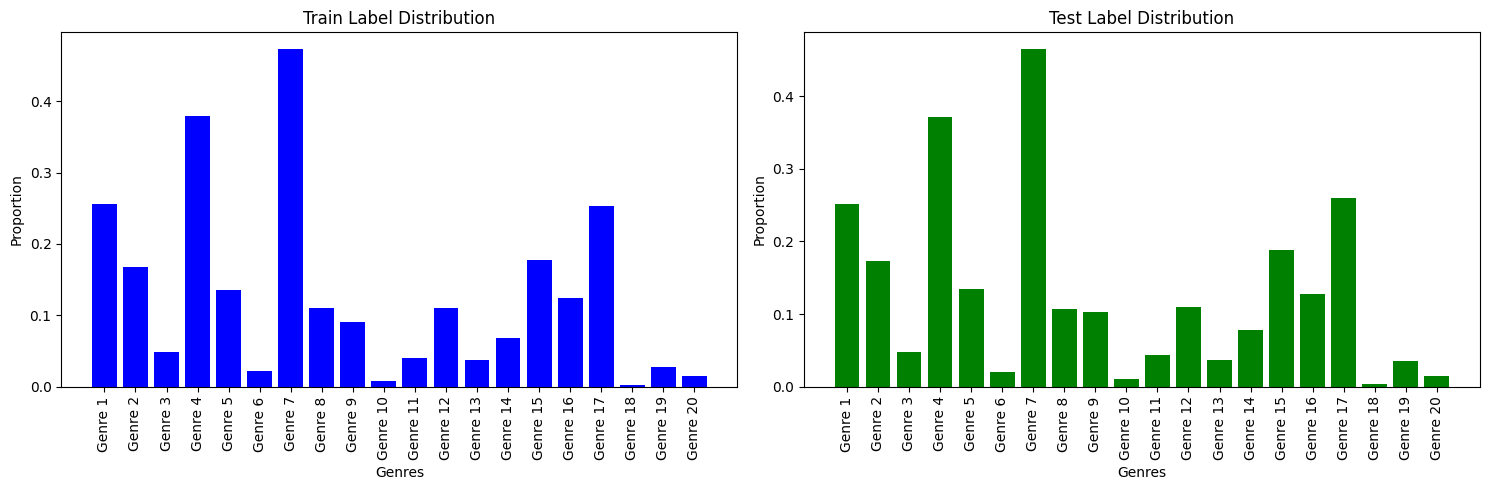

In [ ]:
# Checkpoint
import numpy as np
import matplotlib.pyplot as plt

def label_distribution(y):
    return np.sum(y, axis=0) / y.shape[0]

train_distribution = label_distribution(y_train)
test_distribution = label_distribution(y_test)

# Plotting the bar chart
labels = [f"Genre {i+1}" for i in range(len(train_distribution))]  # Replace with actual genre names if available

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Train label distribution bar chart
ax[0].bar(labels, train_distribution, color='blue')
ax[0].set_title("Train Label Distribution")
ax[0].set_xlabel("Genres")
ax[0].set_ylabel("Proportion")
ax[0].tick_params(axis='x', rotation=90)

# Test label distribution bar chart
ax[1].bar(labels, test_distribution, color='green')
ax[1].set_title("Test Label Distribution")
ax[1].set_xlabel("Genres")
ax[1].set_ylabel("Proportion")
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()



### 3. TEXT EMBEDDING USING BERT

In [ ]:
!pip install transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [11]:
from sentence_transformers import SentenceTransformer

# use the simple one
model = SentenceTransformer('all-MiniLM-L6-v2')

# X_train dan X_test adalah list of strings
X_train_bert = model.encode(X_train, show_progress_bar=True)
X_test_bert = model.encode(X_test, show_progress_bar=True)





/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

### 4. MODELLING

### 4.1. RANDOM FOREST

In [12]:
from sklearn.ensemble import RandomForestClassifier
# rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample')  # You can tune parameters
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced_subsample',
    criterion='entropy',
    random_state=42
)
rf_model_multi = MultiOutputClassifier(rf_model)

# Train the model with binarized labels
rf_model_multi.fit(X_train_bert, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                       criterion='entropy',
                                                       max_depth=25,
                                                       min_samples_leaf=5,
                                                       min_samples_split=10,
                                                       n_estimators=300,
                                                       random_state=42))

In [13]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_rf = np.array([
    estimator.predict_proba(X_test_bert)[:, 1]
    for estimator in rf_model_multi.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [14]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_rf_val = build_conformal_sets(y_test_probs_rf, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_rf_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=1 | Length=0.4865 | Metric=0.7433
Threshold=0.15 | Coverage=0 | Length=0.6249 | Metric=0.3124
Threshold=0.20 | Coverage=0 | Length=0.7135 | Metric=0.3567
Threshold=0.25 | Coverage=0 | Length=0.7762 | Metric=0.3881
Threshold=0.30 | Coverage=0 | Length=0.8249 | Metric=0.4124
Threshold=0.35 | Coverage=0 | Length=0.8662 | Metric=0.4331
Threshold=0.40 | Coverage=0 | Length=0.8985 | Metric=0.4493
Threshold=0.45 | Coverage=0 | Length=0.9254 | Metric=0.4627
Threshold=0.50 | Coverage=0 | Length=0.9528 | Metric=0.4764
Threshold=0.55 | Coverage=0 | Length=0.9731 | Metric=0.4866
Threshold=0.60 | Coverage=0 | Length=0.9888 | Metric=0.4944
Threshold=0.65 | Coverage=0 | Length=0.9961 | Metric=0.4980
Threshold=0.70 | Coverage=0 | Length=0.9987 | Metric=0.4993
Threshold=0.75 | Coverage=0 | Length=0.9997 | Metric=0.4998
Threshold=0.80 | Coverage=0 | Length=1.0000 | Metric=0.5000
Threshold=0.85 | Coverage=0 | Length=1.0000 | Metric=0.5000
Threshold=0.90 | Coverage=0 | Length=1.0

In [15]:
# EVALUATION WITH F1 SCORE

In [ ]:
from sklearn.metrics import classification_report

# Prediksi
y_pred_rf_bert = rf_model_multi.predict(X_test_bert)

# Evaluasi
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rf_bert, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.85      0.28      0.42       122
      Adventure       0.75      0.11      0.19        84
      Animation       0.00      0.00      0.00        23
         Comedy       0.70      0.43      0.53       180
          Crime       0.90      0.13      0.23        67
    Documentary       0.00      0.00      0.00        10
          Drama       0.63      0.57      0.60       225
         Family       0.60      0.06      0.11        52
        Fantasy       0.00      0.00      0.00        48
        Foreign       0.00      0.00      0.00         5
        History       0.00      0.00      0.00        21
         Horror       0.92      0.21      0.34        53
          Music       0.00      0.00      0.00        18
        Mystery       0.00      0.00      0.00        36
        Romance       0.83      0.16      0.28        91
Science.Fiction       1.00      0.15      0.25        62
       Thriller       0.76    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.multiclass import OneVsRestClassifier

rf_model_ovr = OneVsRestClassifier(RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
))

rf_model_ovr.fit(X_train_bert, y_train)


OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     n_estimators=200,
                                                     random_state=42))

In [ ]:
y_pred_bert_ovr = rf_model_ovr.predict(X_test_bert)
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_bert_ovr, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.93      0.11      0.19       122
      Adventure       0.50      0.01      0.02        84
      Animation       0.00      0.00      0.00        23
         Comedy       0.75      0.29      0.42       180
          Crime       1.00      0.04      0.09        67
    Documentary       0.00      0.00      0.00        10
          Drama       0.65      0.54      0.59       225
         Family       0.00      0.00      0.00        52
        Fantasy       0.00      0.00      0.00        48
        Foreign       0.00      0.00      0.00         5
        History       0.00      0.00      0.00        21
         Horror       1.00      0.08      0.14        53
          Music       0.00      0.00      0.00        18
        Mystery       0.00      0.00      0.00        36
        Romance       0.67      0.02      0.04        91
Science.Fiction       1.00      0.03      0.06        62
       Thriller       0.89    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.2. LOG REGRESSION

In [16]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Menambahkan parameter class_weight='balanced' untuk mengatasi data imbalance
# lr = OneVsRestClassifier(LogisticRegression(max_iter=3000, class_weight='balanced'))
lr = OneVsRestClassifier(
    LogisticRegression(
        C=1.5,                    # regularisasi lebih kuat (tweak ini)
        penalty='l2',             # default, aman
        solver='liblinear',       # cocok buat dataset kecil-menengah
        class_weight='balanced', # ini penting buat imbalance
        max_iter=3000,
        random_state=42
    ),
    n_jobs=-1  # untuk training paralel per-label
)
lr.fit(X_train_bert, y_train)


OneVsRestClassifier(estimator=LogisticRegression(C=1.5, class_weight='balanced',
                                                 max_iter=3000, random_state=42,
                                                 solver='liblinear'),
                    n_jobs=-1)

In [17]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_lr = np.array([
    estimator.predict_proba(X_test_bert)[:, 1]
    for estimator in lr.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [18]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_lr_val = build_conformal_sets(y_test_probs_lr, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_lr_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=1 | Length=0.4191 | Metric=0.7095
Threshold=0.15 | Coverage=1 | Length=0.5117 | Metric=0.7559
Threshold=0.20 | Coverage=0 | Length=0.5797 | Metric=0.2898
Threshold=0.25 | Coverage=0 | Length=0.6330 | Metric=0.3165
Threshold=0.30 | Coverage=0 | Length=0.6823 | Metric=0.3411
Threshold=0.35 | Coverage=0 | Length=0.7191 | Metric=0.3595
Threshold=0.40 | Coverage=0 | Length=0.7492 | Metric=0.3746
Threshold=0.45 | Coverage=0 | Length=0.7793 | Metric=0.3896
Threshold=0.50 | Coverage=0 | Length=0.8066 | Metric=0.4033
Threshold=0.55 | Coverage=0 | Length=0.8309 | Metric=0.4155
Threshold=0.60 | Coverage=0 | Length=0.8536 | Metric=0.4268
Threshold=0.65 | Coverage=0 | Length=0.8763 | Metric=0.4382
Threshold=0.70 | Coverage=0 | Length=0.8974 | Metric=0.4487
Threshold=0.75 | Coverage=0 | Length=0.9185 | Metric=0.4592
Threshold=0.80 | Coverage=0 | Length=0.9353 | Metric=0.4676
Threshold=0.85 | Coverage=0 | Length=0.9545 | Metric=0.4772
Threshold=0.90 | Coverage=0 | Length=0.9

In [19]:
# EVALUATION WITH F1

In [ ]:

# Predict
y_pred_bert_lr = lr.predict(X_test_bert)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred_bert_lr, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.59      0.72      0.65       122
      Adventure       0.46      0.76      0.57        84
      Animation       0.25      0.61      0.36        23
         Comedy       0.64      0.74      0.69       180
          Crime       0.45      0.73      0.56        67
    Documentary       0.16      0.60      0.25        10
          Drama       0.65      0.69      0.67       225
         Family       0.39      0.71      0.51        52
        Fantasy       0.35      0.65      0.45        48
        Foreign       0.10      0.20      0.13         5
        History       0.26      0.67      0.38        21
         Horror       0.51      0.75      0.61        53
          Music       0.31      0.72      0.43        18
        Mystery       0.21      0.58      0.30        36
        Romance       0.48      0.77      0.59        91
Science.Fiction       0.51      0.76      0.61        62
       Thriller       0.51    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_probs = lr.predict_proba(X_test_bert)
y_pred_custom = (y_probs >= 0.475).astype(int)

print(classification_report(y_test, y_pred_custom, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.57      0.75      0.65       122
      Adventure       0.45      0.79      0.57        84
      Animation       0.25      0.61      0.35        23
         Comedy       0.62      0.77      0.69       180
          Crime       0.44      0.76      0.56        67
    Documentary       0.15      0.60      0.24        10
          Drama       0.63      0.70      0.66       225
         Family       0.38      0.77      0.51        52
        Fantasy       0.33      0.65      0.43        48
        Foreign       0.09      0.20      0.12         5
        History       0.25      0.67      0.36        21
         Horror       0.45      0.75      0.57        53
          Music       0.29      0.72      0.41        18
        Mystery       0.19      0.58      0.28        36
        Romance       0.44      0.77      0.56        91
Science.Fiction       0.50      0.77      0.61        62
       Thriller       0.50    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.3. MLP

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Create an MLPClassifier model (Neural Network)
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Wrap the MLPClassifier in MultiOutputClassifier for multi-label classification
mlp_model_multi = MultiOutputClassifier(mlp_model)

# Train the model on the training data
mlp_model_multi.fit(X_train_bert, y_train)

MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=(100, 50),
                                              max_iter=1000, random_state=42))

In [21]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_mlp = np.array([
    estimator.predict_proba(X_test_bert)[:, 1]
    for estimator in mlp_model_multi.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [22]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_mlp_val = build_conformal_sets(y_test_probs_mlp, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_mlp_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=0 | Length=0.8523 | Metric=0.4261
Threshold=0.15 | Coverage=0 | Length=0.8630 | Metric=0.4315
Threshold=0.20 | Coverage=0 | Length=0.8688 | Metric=0.4344
Threshold=0.25 | Coverage=0 | Length=0.8746 | Metric=0.4373
Threshold=0.30 | Coverage=0 | Length=0.8789 | Metric=0.4395
Threshold=0.35 | Coverage=0 | Length=0.8828 | Metric=0.4414
Threshold=0.40 | Coverage=0 | Length=0.8863 | Metric=0.4432
Threshold=0.45 | Coverage=0 | Length=0.8899 | Metric=0.4450
Threshold=0.50 | Coverage=0 | Length=0.8938 | Metric=0.4469
Threshold=0.55 | Coverage=0 | Length=0.8965 | Metric=0.4482
Threshold=0.60 | Coverage=0 | Length=0.8991 | Metric=0.4495
Threshold=0.65 | Coverage=0 | Length=0.9030 | Metric=0.4515
Threshold=0.70 | Coverage=0 | Length=0.9073 | Metric=0.4536
Threshold=0.75 | Coverage=0 | Length=0.9115 | Metric=0.4558
Threshold=0.80 | Coverage=0 | Length=0.9161 | Metric=0.4580
Threshold=0.85 | Coverage=0 | Length=0.9200 | Metric=0.4600
Threshold=0.90 | Coverage=0 | Length=0.9

In [23]:
# EVALUATION USING F1 SCORE

In [ ]:
# Predict
y_pred_bert_nn = mlp_model_multi.predict(X_test_bert)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred_bert_nn, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.70      0.60      0.64       122
      Adventure       0.58      0.49      0.53        84
      Animation       0.67      0.26      0.38        23
         Comedy       0.68      0.69      0.69       180
          Crime       0.62      0.43      0.51        67
    Documentary       0.40      0.20      0.27        10
          Drama       0.62      0.60      0.61       225
         Family       0.54      0.40      0.46        52
        Fantasy       0.36      0.21      0.26        48
        Foreign       0.00      0.00      0.00         5
        History       0.64      0.33      0.44        21
         Horror       0.69      0.62      0.65        53
          Music       0.58      0.39      0.47        18
        Mystery       0.26      0.14      0.18        36
        Romance       0.61      0.48      0.54        91
Science.Fiction       0.67      0.55      0.60        62
       Thriller       0.57    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.4. SVC

In [24]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss

svm = SVC(
    kernel='rbf',
    C=10,
    gamma=0.1,
    class_weight='balanced',
    tol=1e-6,
    max_iter=10000,
    probability=True
)
multi_svm = MultiOutputClassifier(svm)
multi_svm.fit(X_train_bert, y_train)


MultiOutputClassifier(estimator=SVC(C=10, class_weight='balanced', gamma=0.1,
                                    max_iter=10000, probability=True,
                                    tol=1e-06))

In [26]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_svc = np.array([
    estimator.predict_proba(X_test_bert)[:, 1]
    for estimator in multi_svm.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [27]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_svc_val = build_conformal_sets(y_test_probs_svc, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_svc_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=0 | Length=0.6857 | Metric=0.3428
Threshold=0.15 | Coverage=0 | Length=0.7491 | Metric=0.3745
Threshold=0.20 | Coverage=0 | Length=0.7919 | Metric=0.3960
Threshold=0.25 | Coverage=0 | Length=0.8228 | Metric=0.4114
Threshold=0.30 | Coverage=0 | Length=0.8483 | Metric=0.4242
Threshold=0.35 | Coverage=0 | Length=0.8677 | Metric=0.4339
Threshold=0.40 | Coverage=0 | Length=0.8857 | Metric=0.4428
Threshold=0.45 | Coverage=0 | Length=0.9013 | Metric=0.4507
Threshold=0.50 | Coverage=0 | Length=0.9144 | Metric=0.4572
Threshold=0.55 | Coverage=0 | Length=0.9311 | Metric=0.4656
Threshold=0.60 | Coverage=0 | Length=0.9417 | Metric=0.4709
Threshold=0.65 | Coverage=0 | Length=0.9527 | Metric=0.4763
Threshold=0.70 | Coverage=0 | Length=0.9638 | Metric=0.4819
Threshold=0.75 | Coverage=0 | Length=0.9729 | Metric=0.4865
Threshold=0.80 | Coverage=0 | Length=0.9815 | Metric=0.4908
Threshold=0.85 | Coverage=0 | Length=0.9884 | Metric=0.4942
Threshold=0.90 | Coverage=0 | Length=0.9

In [28]:
# EVALUATION USING F1 SCORE

In [29]:
# Predict
y_pred_bert_svc = multi_svm.predict(X_test_bert)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred_bert_svc, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.59      0.70      0.64       122
      Adventure       0.46      0.67      0.54        85
      Animation       0.21      0.26      0.24        23
         Comedy       0.63      0.74      0.68       180
          Crime       0.43      0.77      0.55        65
    Documentary       0.33      0.50      0.40        10
          Drama       0.62      0.67      0.65       225
         Family       0.36      0.60      0.45        52
        Fantasy       0.32      0.48      0.38        50
        Foreign       0.00      0.00      0.00         5
        History       0.38      0.62      0.47        21
         Horror       0.52      0.74      0.61        53
          Music       0.47      0.50      0.49        18
        Mystery       0.20      0.44      0.27        36
        Romance       0.45      0.71      0.55        92
Science.Fiction       0.56      0.76      0.64        63
       Thriller       0.52    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
probs_class_1 = np.array([prob[:, 1] for prob in multi_svm.predict_proba(X_test_bert)]).T

best_thresholds = []
for i in range(len(genre_columns)):
    best_f1 = 0
    best_t = 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        # Using prob per label
        preds = (probs_class_1[:, i] >= t).astype(int)
        # F1 score
        f1 = f1_score(y_test[:, i], preds, average='binary', zero_division=0)
        # precision, recall, f1, _ = precision_recall_fscore_support(y_test[:, i], preds, average='binary')
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds.append(best_t)

# Predict
y_pred_custom_thresh = np.array([
    [1 if prob >= best_thresholds[j] else 0 for j, prob in enumerate(row)]
    for row in probs_class_1
])

# Evaluate
print(classification_report(y_test, y_pred_custom_thresh, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.58      0.76      0.66       122
      Adventure       0.47      0.73      0.57        84
      Animation       0.32      0.43      0.37        23
         Comedy       0.65      0.76      0.70       180
          Crime       0.46      0.70      0.55        67
    Documentary       0.38      0.50      0.43        10
          Drama       0.60      0.88      0.71       225
         Family       0.49      0.62      0.55        52
        Fantasy       0.29      0.58      0.39        48
        Foreign       0.00      0.00      0.00         5
        History       0.53      0.43      0.47        21
         Horror       0.78      0.58      0.67        53
          Music       0.88      0.39      0.54        18
        Mystery       0.23      0.44      0.30        36
        Romance       0.55      0.64      0.59        91
Science.Fiction       0.64      0.63      0.63        62
       Thriller       0.55    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.5. XGBOOST

In [30]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Inisialisasi base model XGBoost
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    scale_pos_weight=1,  # bisa kamu sesuaikan nanti per label kalau perlu
    verbosity=1
)

# Bungkus dalam MultiOutputClassifier
multi_xgb = MultiOutputClassifier(xgb)

# Fit model ke data BERT embeddings
multi_xgb.fit(X_train_bert, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:47:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:47:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:47:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:47:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:47:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

In [31]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_xgb= np.array([
    estimator.predict_proba(X_test_bert)[:, 1]
    for estimator in multi_xgb.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [32]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_xgb_val = build_conformal_sets(y_test_probs_xgb, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_xgb_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=0 | Length=0.8278 | Metric=0.4139
Threshold=0.15 | Coverage=0 | Length=0.8567 | Metric=0.4284
Threshold=0.20 | Coverage=0 | Length=0.8757 | Metric=0.4379
Threshold=0.25 | Coverage=0 | Length=0.8901 | Metric=0.4451
Threshold=0.30 | Coverage=0 | Length=0.9013 | Metric=0.4507
Threshold=0.35 | Coverage=0 | Length=0.9120 | Metric=0.4560
Threshold=0.40 | Coverage=0 | Length=0.9214 | Metric=0.4607
Threshold=0.45 | Coverage=0 | Length=0.9314 | Metric=0.4657
Threshold=0.50 | Coverage=0 | Length=0.9384 | Metric=0.4692
Threshold=0.55 | Coverage=0 | Length=0.9460 | Metric=0.4730
Threshold=0.60 | Coverage=0 | Length=0.9533 | Metric=0.4767
Threshold=0.65 | Coverage=0 | Length=0.9612 | Metric=0.4806
Threshold=0.70 | Coverage=0 | Length=0.9676 | Metric=0.4838
Threshold=0.75 | Coverage=0 | Length=0.9733 | Metric=0.4867
Threshold=0.80 | Coverage=0 | Length=0.9811 | Metric=0.4906
Threshold=0.85 | Coverage=0 | Length=0.9857 | Metric=0.4928
Threshold=0.90 | Coverage=0 | Length=0.9

In [33]:
# EVALUATION WITH F1 SCORE

In [ ]:
# Predict
y_pred_bert_xgb = multi_xgb.predict(X_test_bert)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred_bert_xgb, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.72      0.41      0.52       122
      Adventure       0.65      0.18      0.28        84
      Animation       0.00      0.00      0.00        23
         Comedy       0.70      0.51      0.59       180
          Crime       0.76      0.19      0.31        67
    Documentary       0.00      0.00      0.00        10
          Drama       0.62      0.59      0.60       225
         Family       0.67      0.12      0.20        52
        Fantasy       0.50      0.02      0.04        48
        Foreign       0.00      0.00      0.00         5
        History       0.00      0.00      0.00        21
         Horror       0.94      0.30      0.46        53
          Music       1.00      0.11      0.20        18
        Mystery       0.00      0.00      0.00        36
        Romance       0.75      0.26      0.39        91
Science.Fiction       0.71      0.32      0.44        62
       Thriller       0.59    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## CONCLUSION: THE BEST MODEL IS LOG REGRESSION EITHER WITH F1 SCORE OR COVERAGE-LENGTH METRICS.